# Uncovering Air Quality Patterns Through the Lens of Urban Amenities
Using Data-Driven Insights to Understand the Role of Urban Spaces in Air Quality Trends

## Machine Learning Phase

Presented By:
**Learning Team 3**
- Francis Mark M. Cayco
- Eros Paul V. Estante
- Andgrel Heber M. Jison
- Angela Elaine F. Pelayo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

import optuna
from optuna.visualization import plot_intermediate_values

import xgboost as xgb
import lightgbm as lgb

import dice_ml

OUTPUT_DIR = 'outputs'

In [2]:
df = pd.read_parquet(f'{OUTPUT_DIR}/AirQualityAmenityCount.parquet')
df['main.aqi'] = df['main.aqi'] - 1
df.drop(['Current Hour'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['Time of Day','Quarter'])
display(df)

,datetime,city_name,coord.lon,coord.lat,main.aqi,Day of Week,Is Weekend,restaurant,school,bank,...,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_1,Quarter_2,Quarter_3,Quarter_4
0,2023-11-06 15:00:00+08:00,Alaminos,119.9811,16.1561,1,Monday,False,20,4,12,...,0,0,1,0,0,0,0,0,0,1
1,2023-11-06 18:00:00+08:00,Alaminos,119.9811,16.1561,1,Monday,False,20,4,12,...,0,0,0,1,0,0,0,0,0,1
2,2023-11-07 00:00:00+08:00,Alaminos,119.9811,16.1561,1,Tuesday,False,20,4,12,...,0,0,0,0,0,1,0,0,0,1
3,2023-11-07 06:00:00+08:00,Alaminos,119.9811,16.1561,0,Tuesday,False,20,4,12,...,0,0,0,0,1,0,0,0,0,1
4,2023-11-07 12:00:00+08:00,Alaminos,119.9811,16.1561,2,Tuesday,False,20,4,12,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609087,2025-03-15 09:00:00+08:00,Zamboanga City,122.0696,6.9135,0,Saturday,True,44,10,28,...,1,0,0,0,1,0,1,0,0,0
609088,2025-03-15 10:00:00+08:00,Zamboanga City,122.0696,6.9135,1,Saturday,True,44,10,28,...,1,0,0,0,1,0,1,0,0,0
609089,2025-03-15 11:00:00+08:00,Zamboanga City,122.0696,6.9135,1,Saturday,True,44,10,28,...,1,0,0,0,1,0,1,0,0,0
609090,2025-03-15 12:00:00+08:00,Zamboanga City,122.0696,6.9135,0,Saturday,True,44,10,28,...,1,0,1,0,0,0,1,0,0,0


In [3]:
X = df.drop(columns=['main.aqi','city_name','coord.lon','coord.lat','datetime','Day of Week']).astype(float)
y = df['main.aqi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

display(X)

,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_1,Quarter_2,Quarter_3,Quarter_4
0,0.0,20.0,4.0,12.0,6.0,6.0,11.0,11.0,4.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,20.0,4.0,12.0,6.0,6.0,11.0,11.0,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,20.0,4.0,12.0,6.0,6.0,11.0,11.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,20.0,4.0,12.0,6.0,6.0,11.0,11.0,4.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,20.0,4.0,12.0,6.0,6.0,11.0,11.0,4.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609087,1.0,44.0,10.0,28.0,35.0,10.0,11.0,39.0,6.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
609088,1.0,44.0,10.0,28.0,35.0,10.0,11.0,39.0,6.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
609089,1.0,44.0,10.0,28.0,35.0,10.0,11.0,39.0,6.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
609090,1.0,44.0,10.0,28.0,35.0,10.0,11.0,39.0,6.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Define the Proportional Chance Criterion (PCC) metric

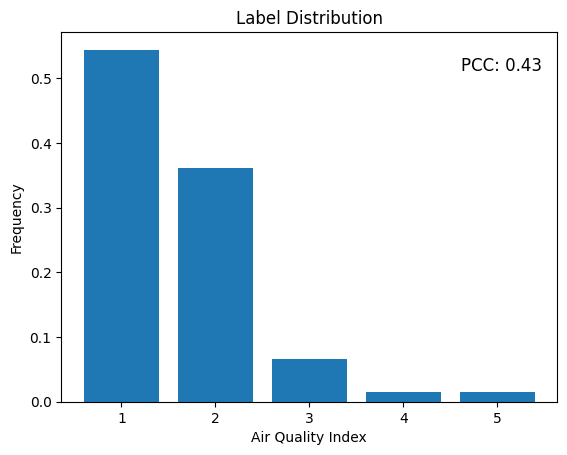

In [4]:
y_counts = y.value_counts(normalize=True)
plt.bar(y_counts.index + 1, y_counts.values)
pcc = (y_counts.values ** 2).sum()

plt.text(0.75, 0.8, f'PCC: {pcc:.2f}', fontsize=12, transform=plt.gcf().transFigure)
plt.xlabel('Air Quality Index')
plt.ylabel('Frequency')

plt.title('Label Distribution')
plt.show()

## Hyperparameter Tuning Using Optuna

### Accuracy without resampling

In [7]:
def objective(trial):
    # Suggest classifier type
    classifier_name = trial.suggest_categorical("classifier", ["XGBoost", "RandomForest", "LogisticRegression"]) # , "LightGBM"

    if classifier_name == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10),
        }
        model = xgb.XGBClassifier(**params, eval_metric="logloss")

    elif classifier_name == "RandomForest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        }
        model = RandomForestClassifier(**params)

    elif classifier_name == "LogisticRegression":
        params = {
            "C": trial.suggest_float("C", 1e-3, 10, log=True),
            "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga"]),
            "max_iter": trial.suggest_int("max_iter", 100, 1000, step=100),
        }
        model = LogisticRegression(**params)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    
    return recall  

no_rs_study = optuna.create_study(direction="maximize", study_name='WithoutResampling')
no_rs_study.optimize(objective, n_trials=10, n_jobs=-1)  # Parallel tuning on GPU

[I 2025-03-19 15:03:41,917] A new study created in memory with name: WithoutResampling
[I 2025-03-19 15:07:14,027] Trial 7 finished with value: 0.5989623950286901 and parameters: {'classifier': 'LogisticRegression', 'C': 7.030214007562241, 'solver': 'saga', 'max_iter': 300}. Best is trial 7 with value: 0.5989623950286901.
[I 2025-03-19 15:08:09,099] Trial 5 finished with value: 0.6672604437731389 and parameters: {'classifier': 'XGBoost', 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1310853045715532, 'subsample': 0.6328567562302678, 'colsample_bytree': 0.5483187342375526, 'gamma': 1.2667294969667302, 'reg_alpha': 6.621979269008816, 'reg_lambda': 2.733391150510558}. Best is trial 5 with value: 0.6672604437731389.
[I 2025-03-19 15:11:40,452] Trial 0 finished with value: 0.6355740894277576 and parameters: {'classifier': 'RandomForest', 'n_estimators': 500, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 5 with value: 0.66726044377

In [8]:
model = xgb.XGBClassifier(**no_rs_study.best_params) 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
# The model is performing better than chance (accuracy > PPC).

/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:20:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "classifier" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.73      0.81      0.77     66248
           1       0.58      0.61      0.60     43963
           2       0.37      0.05      0.09      8020
           3       0.31      0.00      0.01      1800
           4       0.35      0.21      0.27      1788

    accuracy                           0.67    121819
   macro avg       0.47      0.34      0.35    121819
weighted avg       0.64      0.67      0.64    121819



### With Resampling

In [9]:
X_resampled, y_resampled = RandomUnderSampler(
    sampling_strategy={
        0: round(0.15*264990),
        1: round(0.20*175853),
        2: round(0.87*32077),
        3: 7200,
        4: 7153
    }
).fit_resample(X_train, y_train)
X_resampled, y_resampled = SMOTE().fit_resample(X_resampled, y_resampled)

y_resampled.value_counts()

0    39748
1    39748
2    39748
3    39748
4    39748
Name: main.aqi, dtype: int64

In [10]:
def objective(trial):
    # Suggest classifier type
    classifier_name = trial.suggest_categorical("classifier", ["XGBoost", "RandomForest", "LogisticRegression"]) # , "LightGBM"

    if classifier_name == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10),
        }
        model = xgb.XGBClassifier(**params, eval_metric="logloss")

    elif classifier_name == "RandomForest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        }
        model = RandomForestClassifier(**params)

    elif classifier_name == "LogisticRegression":
        params = {
            "C": trial.suggest_float("C", 1e-3, 10, log=True),
            "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga"]),
            "max_iter": trial.suggest_int("max_iter", 100, 1000, step=100),
        }
        model = LogisticRegression(**params)

    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    
    return recall  

rs_study = optuna.create_study(direction="maximize", study_name='WithResampling')
rs_study.optimize(objective, n_trials=10, n_jobs=-1)  # Parallel tuning on GPU

[I 2025-03-19 15:23:25,131] A new study created in memory with name: WithResampling


[I 2025-03-19 15:23:33,841] Trial 3 finished with value: 0.47279160065342846 and parameters: {'classifier': 'LogisticRegression', 'C': 0.0025699080769355006, 'solver': 'saga', 'max_iter': 300}. Best is trial 3 with value: 0.47279160065342846.
[I 2025-03-19 15:23:49,767] Trial 8 finished with value: 0.5007346965580082 and parameters: {'classifier': 'LogisticRegression', 'C': 1.0716532390910536, 'solver': 'liblinear', 'max_iter': 200}. Best is trial 8 with value: 0.5007346965580082.
[I 2025-03-19 15:24:30,539] Trial 4 finished with value: 0.5387254861721078 and parameters: {'classifier': 'RandomForest', 'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 4 with value: 0.5387254861721078.
[I 2025-03-19 15:26:27,210] Trial 0 finished with value: 0.5453911130447632 and parameters: {'classifier': 'RandomForest', 'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 9, 'bootstrap': False}. Best is tr

In [11]:
model = xgb.XGBClassifier(**rs_study.best_params) 
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:27:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "classifier" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.80      0.66      0.73     66248
           1       0.59      0.46      0.51     43963
           2       0.19      0.38      0.25      8020
           3       0.07      0.33      0.12      1800
           4       0.14      0.71      0.23      1788

    accuracy                           0.57    121819
   macro avg       0.36      0.51      0.37    121819
weighted avg       0.67      0.57      0.60    121819



In [12]:
print(rs_study.best_params)

{'classifier': 'XGBoost', 'n_estimators': 300, 'max_depth': 13, 'learning_rate': 0.2560365384334953, 'subsample': 0.8546928034208474, 'colsample_bytree': 0.6753230931609567, 'gamma': 0.6684428579940282, 'reg_alpha': 8.173597230971836, 'reg_lambda': 5.643967453124724}


## Year-Round Analysis

In [13]:
model = xgb.XGBClassifier(**rs_study.best_params) 

model.fit(X_train, y_train)
# model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
# The model is performing better than chance (accuracy > PPC).

/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:28:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "classifier" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.73      0.81      0.77     66248
           1       0.58      0.61      0.60     43963
           2       0.36      0.06      0.10      8020
           3       0.24      0.01      0.01      1800
           4       0.35      0.22      0.27      1788

    accuracy                           0.67    121819
   macro avg       0.45      0.34      0.35    121819
weighted avg       0.64      0.67      0.64    121819



 warnings.warn(smsg, UserWarning)
              precision    recall  f1-score   support

           0       0.79      0.67      0.72     66248
           1       0.58      0.43      0.49     43963
           2       0.18      0.29      0.22      8020
           3       0.06      0.36      0.10      1800
           4       0.14      0.73      0.24      1788

    accuracy                           0.55    121819
   macro avg       0.35      0.50      0.36    121819
weighted avg       0.65      0.55      0.59    121819

### Individual Feature Importances

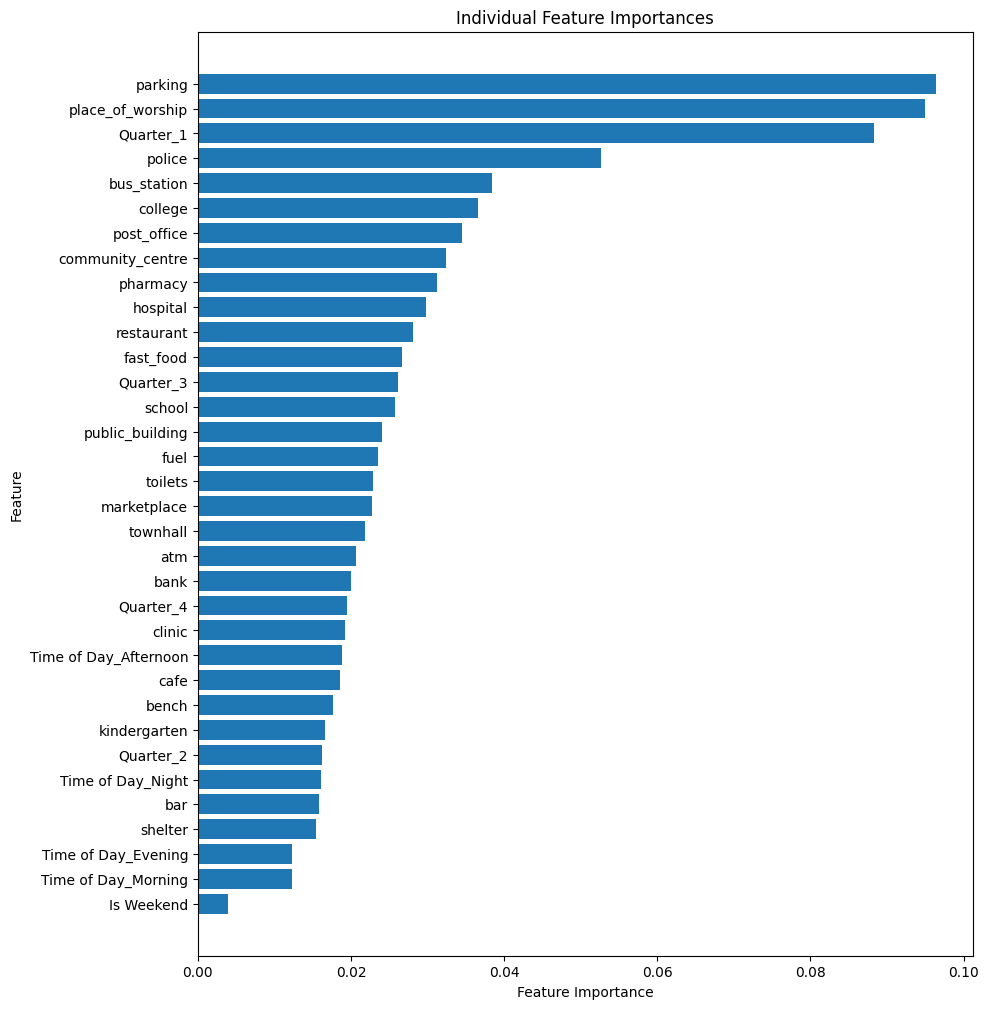

In [14]:
feature_importances = model.feature_importances_
feature_importances_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 12))
plt.barh(X.columns[feature_importances_idx], feature_importances[feature_importances_idx])
plt.title('Individual Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [15]:
y_resampled.value_counts()

0    39748
1    39748
2    39748
3    39748
4    39748
Name: main.aqi, dtype: int64

In [16]:
confusion_matrix(y_test, y_pred)

array([[53727, 12231,   157,     3,   130],
       [16484, 26835,   426,     8,   210],
       [ 2168,  5158,   465,    12,   217],
       [  530,   923,   161,    12,   174],
       [  412,   876,    96,    16,   388]])

### Comparison with SHAP values

In [17]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

Feature importances when AQI = 1


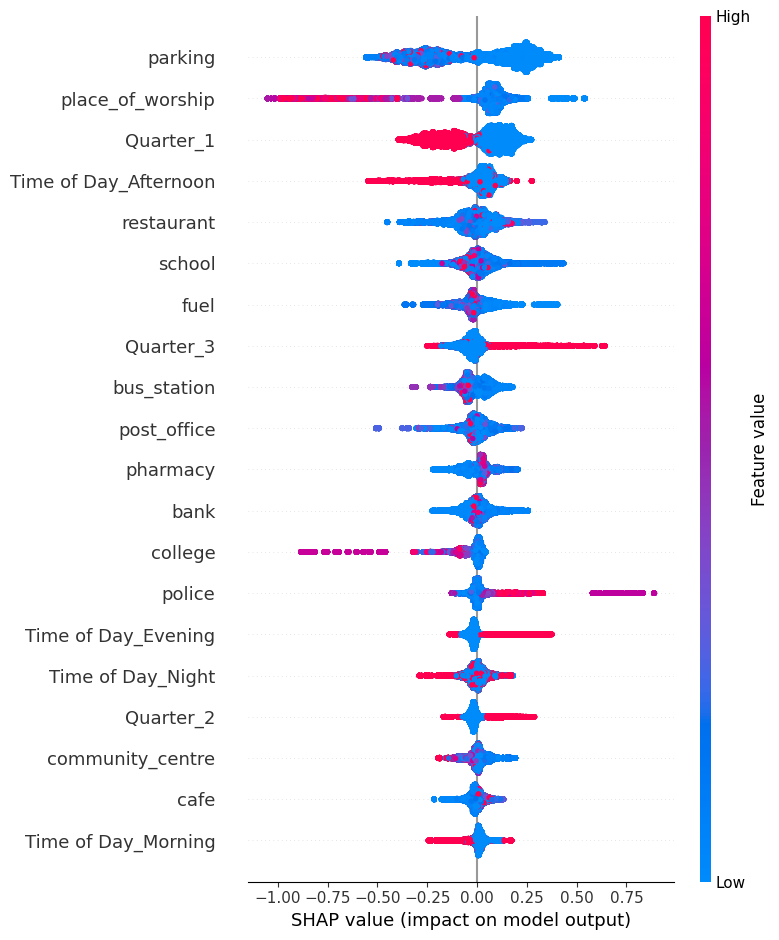

In [18]:
print(f"Feature importances when AQI = 1")
shap.summary_plot(shap_values[:,:,0], X_test, feature_names=X.columns)

In [19]:
shap_values[:,:,1].shape

(121819, 34)

Feature importances when AQI = 2


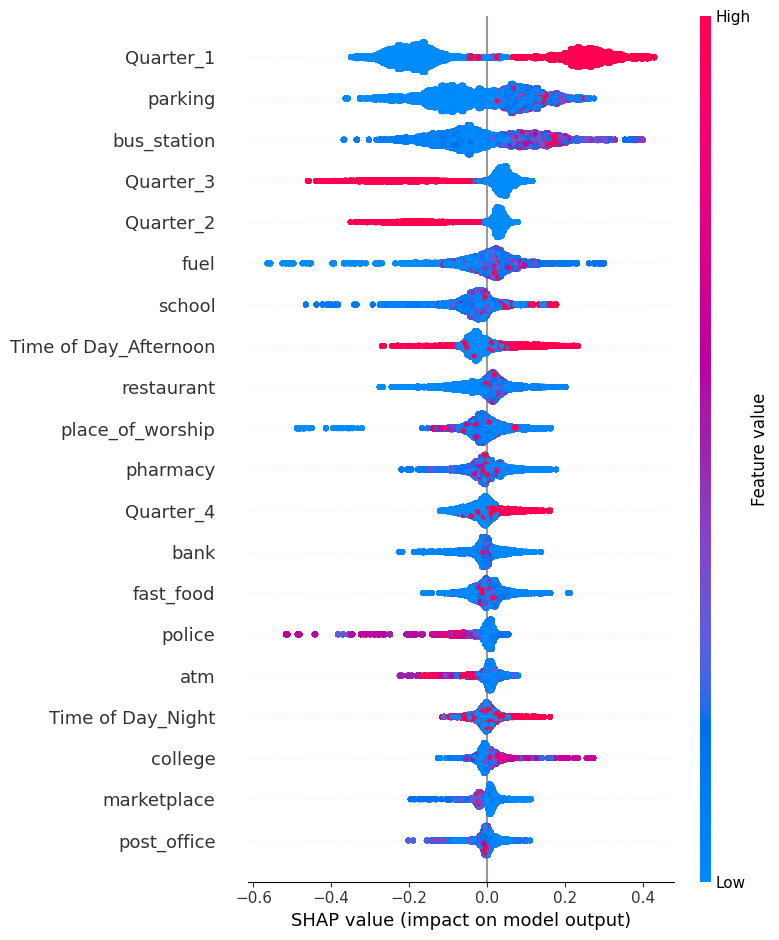

In [20]:
print(f"Feature importances when AQI = 2")
shap.summary_plot(shap_values[:,:,1], X_test, feature_names=X.columns)

Feature importances when AQI = 3


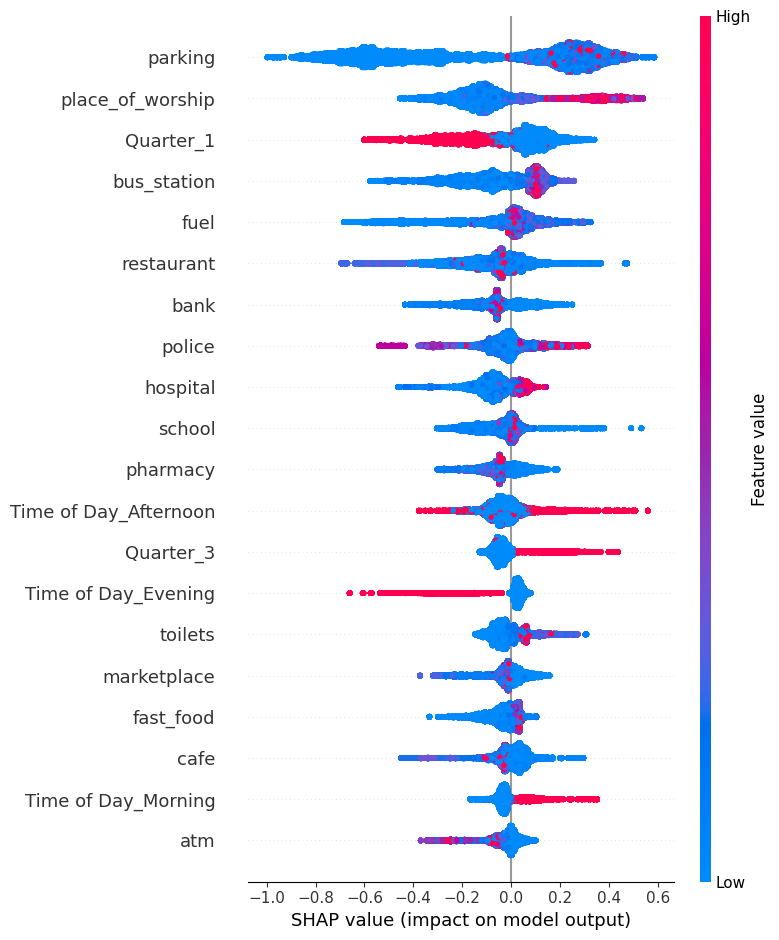

In [21]:
print(f"Feature importances when AQI = 3")
shap.summary_plot(shap_values[:,:,2], X_test, feature_names=X.columns)

Feature importances when AQI = 4


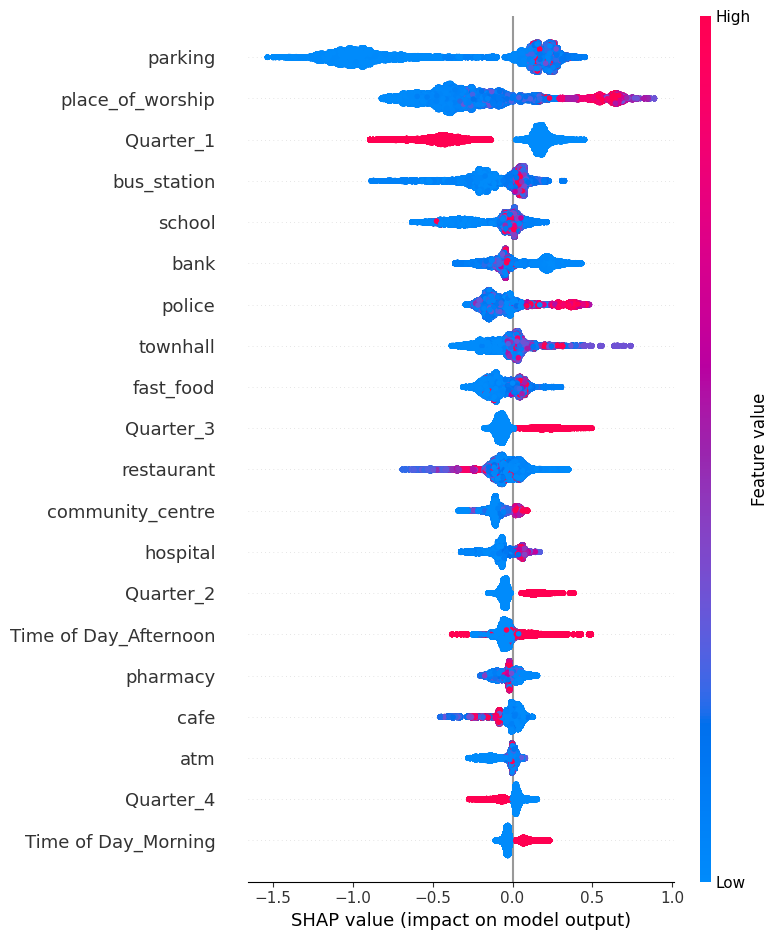

In [22]:
print(f"Feature importances when AQI = 4")
shap.summary_plot(shap_values[:,:,3], X_test, feature_names=X.columns)

Feature importances when AQI = 5


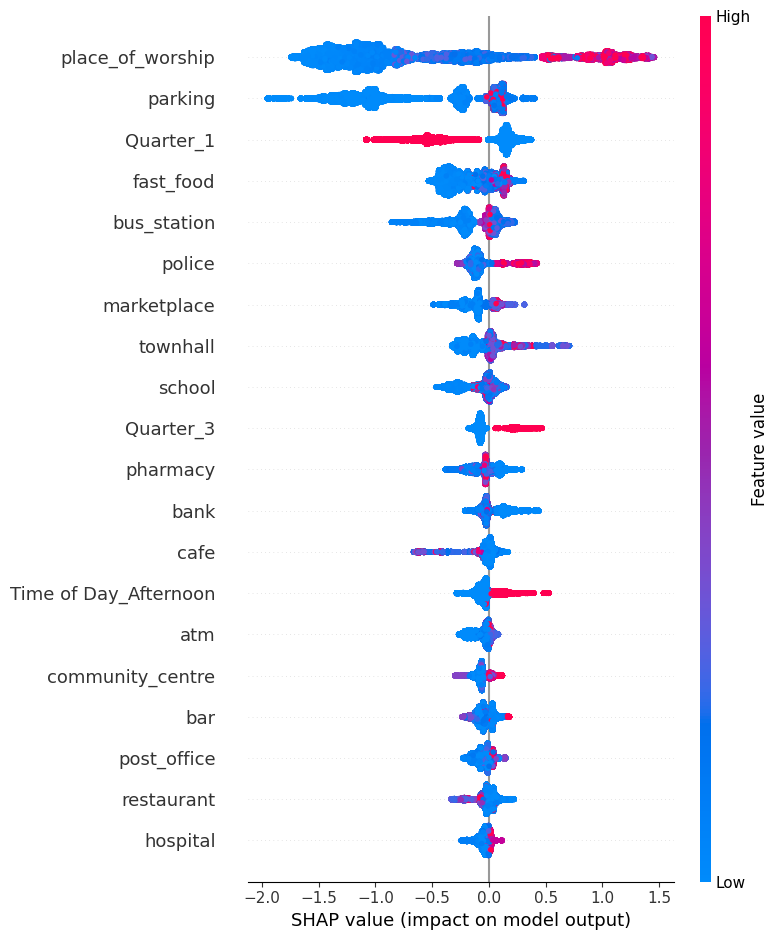

In [23]:
print(f"Feature importances when AQI = 5")
shap.summary_plot(shap_values[:,:,4], X_test, feature_names=X.columns)

## Monthly Analysis

In [24]:
shap_cache = {}
def monthly_shap(month_num:int):
    if month_num in shap_cache:
        return shap_cache[month_num]
    df_filtered = df[ df['datetime'].dt.month == 6]

    X_filtered = df_filtered.drop(columns=['main.aqi','city_name','coord.lon','coord.lat','datetime','Day of Week'])
    y_filtered = df_filtered['main.aqi']

    #
    X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

    sampler = RandomUnderSampler(sampling_strategy='auto')
    X_train_filtered, y_train_filtered = sampler.fit_resample(X_train_filtered, y_train_filtered)

    scaler = MinMaxScaler()
    X_train_filtered = scaler.fit_transform(X_train_filtered)
    X_test_filtered = scaler.transform(X_test_filtered)

    # rs_study.best_params.pop('classifier',None)
    model = xgb.XGBClassifier(**rs_study.best_params)
    model.fit(X_train_filtered, y_train_filtered)

    y_pred = model.predict(X_test_filtered)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_filtered, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test_filtered, y_pred)
    print(f'Precision: {precision}, Recall: {recall}, F1: {f1}')
    print(f'Accuracy: {accuracy}')
    print(classification_report(y_test_filtered, y_pred))

    explainer = shap.Explainer(model)
    shap_values = explainer(X_test_filtered)
    shap_cache[month_num] = shap_values, X_test_filtered

    return shap_values, X_test_filtered

def plot_shap(month, aqi):
    shap_values, X_test_filtered = monthly_shap(month)

    print(f"Feature importances when AQI = {aqi}")
    shap.summary_plot(shap_values[:,:,aqi -1], X_test_filtered, feature_names=X.columns)

/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:30:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "classifier" } are not used.

  warnings.warn(smsg, UserWarning)


Precision: 0.59307122954939, Recall: 0.5440821256038647, F1: 0.5612916156438538
Accuracy: 0.5440821256038647
              precision    recall  f1-score   support

           0       0.81      0.69      0.75      3439
           1       0.43      0.37      0.40      1783
           2       0.29      0.27      0.28       818
           3       0.14      0.39      0.20       264
           4       0.39      0.71      0.50       320

    accuracy                           0.54      6624
   macro avg       0.41      0.49      0.43      6624
weighted avg       0.59      0.54      0.56      6624

Feature importances when AQI = 1


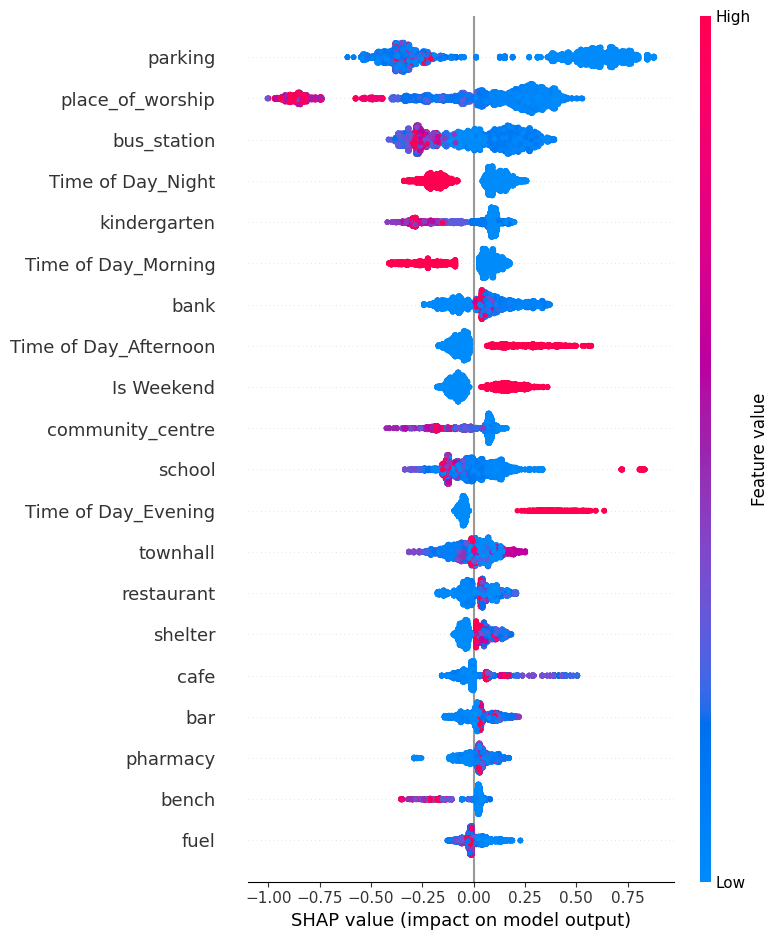

In [25]:
plot_shap(month=4, aqi=1)

Feature importances when AQI = 5


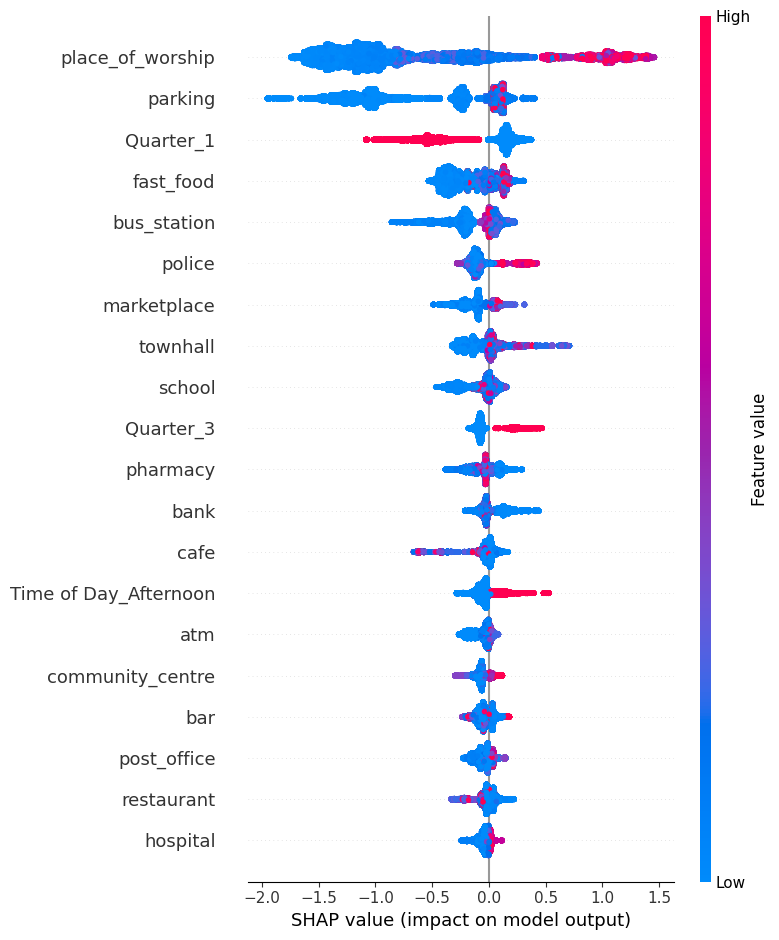

In [26]:
print(f"Feature importances when AQI = 5")
shap.summary_plot(shap_values[:,:,4], X_test, feature_names=X.columns)

## Counterfactual Analysis

In [27]:
df = pd.read_parquet(f'{OUTPUT_DIR}/AirQualityAmenityCount.parquet')

df = df[df['datetime'].dt.month == 9]
df['main.aqi'] = df['main.aqi'] - 1
df.drop(['Current Hour'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['Time of Day','Quarter'])

X = df.drop(columns=['main.aqi','city_name','coord.lon','coord.lat','datetime','Day of Week']).astype(float)
y = df['main.aqi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [28]:
bacoor_morning_data = df[(df['city_name'] == 'Bacoor') & (df['Time of Day_Afternoon'] == True)].index
bacoor_morning_data

Int64Index([19860, 19861, 19868, 19869, 19876, 19877, 19884, 19885, 19892,
            19893, 19900, 19901, 19908, 19909, 19916, 19917, 19924, 19925,
            19932, 19933, 19940, 19941, 19948, 19949, 19956, 19957, 19964,
            19965, 19972, 19973, 19980, 19981, 19988, 19989, 19996, 19997,
            20004, 20005, 20012, 20013, 20020, 20021, 20028, 20029, 20036,
            20037, 20044, 20045, 20052, 20053, 20060, 20061, 20068, 20069,
            20076, 20077, 20084, 20085, 20093, 20094],
           dtype='int64')

In [29]:
categorical_columns = ['Is Weekend', 
       'Time of Day_Afternoon', 'Time of Day_Evening', 'Time of Day_Morning',
       'Time of Day_Night', 'Quarter_1', 'Quarter_2', 'Quarter_3',
       'Quarter_4']
continuous_features = [col for col in X.columns if col not in categorical_columns]

In [30]:
model2 = RandomForestClassifier(n_estimators=100, max_depth=10)

# resampler = RandomUnderSampler(sampling_strategy='auto')
# X_train, y_train = resampler.fit_resample(X_train, y_train)
model2.fit(X_train, y_train)
# Define feature names and target variable
features = X_train.columns.tolist()
target = "main.aqi"  # Replace with actual target column name

In [31]:
# Convert your XGBoost model to a format compatible with DiCE
model_dice = dice_ml.Model(model=model2, backend="sklearn")

# Define the dataset format for DiCE
data_dice = dice_ml.Data(dataframe=pd.concat([X_train, y_train], axis=1), 
                         categorical_features=categorical_columns, 
                            continuous_features=continuous_features,
                         outcome_name=target)

In [32]:
exp = dice_ml.Dice(data_dice, model_dice)

features_to_vary = ['Is Weekend', 'restaurant', 'school', 'bank', 'fast_food',
       'place_of_worship', 'fuel', 'pharmacy', 'cafe', 'parking', 'townhall',
       'bar', 'police', 'atm', 'community_centre', 'bus_station', 'clinic',
       'shelter', 'toilets', 'hospital', 'post_office', 'bench',
       'public_building', 'college', 'marketplace', 'kindergarten',
       ]
query_instance = X.iloc[bacoor_morning_data[:50]] 

# Generate counterfactuals (requesting 3 diverse counterfactuals)
dice_explanation = exp.generate_counterfactuals(query_instance, total_CFs=3, desired_class=2, features_to_vary=features_to_vary)

# Display counterfactuals
dice_explanation.visualize_as_dataframe(show_only_changes=True)

  2%|▏         | 1/50 [00:00<00:19,  2.51it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  4%|▍         | 2/50 [00:00<00:18,  2.57it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  6%|▌         | 3/50 [00:01<00:18,  2.48it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  8%|▊         | 4/50 [00:01<00:18,  2.54it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 10%|█         | 5/50 [00:01<00:17,  2.60it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 12%|█▏        | 6/50 [00:02<00:16,  2.63it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 14%|█▍        | 7/50 [00:02<00:16,  2.67it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 16%|█▌        | 8/50 [00:03<00:15,  2.69it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 18%|█▊        | 9/50 [00:03<00:15,  2.68it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 20%|██        | 10/50 [00:03<00:14,  2.71it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 22%|██▏       | 11/50 [00:04<00:14,  2.74it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 24%|██▍       | 12/50 [00:04<00:13,  2.77it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 26%|██▌       | 13/50 [00:04<00:13,  2.79it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 28%|██▊       | 14/50 [00:05<00:12,  2.81it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 30%|███       | 15/50 [00:05<00:12,  2.81it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 32%|███▏      | 16/50 [00:05<00:12,  2.82it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 34%|███▍      | 17/50 [00:06<00:11,  2.82it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 36%|███▌      | 18/50 [00:06<00:11,  2.82it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 38%|███▊      | 19/50 [00:06<00:10,  2.82it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 20/50 [00:07<00:10,  2.82it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 42%|████▏     | 21/50 [00:07<00:10,  2.81it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 44%|████▍     | 22/50 [00:08<00:09,  2.81it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 46%|████▌     | 23/50 [00:08<00:09,  2.81it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 48%|████▊     | 24/50 [00:08<00:09,  2.80it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 50%|█████     | 25/50 [00:09<00:08,  2.80it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 52%|█████▏    | 26/50 [00:09<00:08,  2.79it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 54%|█████▍    | 27/50 [00:09<00:08,  2.79it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 56%|█████▌    | 28/50 [00:10<00:08,  2.71it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 58%|█████▊    | 29/50 [00:10<00:07,  2.73it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 30/50 [00:10<00:07,  2.75it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 62%|██████▏   | 31/50 [00:11<00:06,  2.77it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 64%|██████▍   | 32/50 [00:11<00:06,  2.79it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 66%|██████▌   | 33/50 [00:12<00:06,  2.80it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 68%|██████▊   | 34/50 [00:12<00:05,  2.79it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 70%|███████   | 35/50 [00:12<00:05,  2.80it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 72%|███████▏  | 36/50 [00:13<00:05,  2.79it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 76%|███████▌  | 38/50 [00:13<00:04,  2.95it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|████████  | 40/50 [00:14<00:03,  2.84it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 82%|████████▏ | 41/50 [00:14<00:03,  2.88it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 84%|████████▍ | 42/50 [00:15<00:02,  2.93it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 86%|████████▌ | 43/50 [00:15<00:02,  2.97it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 88%|████████▊ | 44/50 [00:15<00:01,  3.00it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 90%|█████████ | 45/50 [00:16<00:01,  3.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 92%|█████████▏| 46/50 [00:16<00:01,  3.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 94%|█████████▍| 47/50 [00:16<00:00,  3.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 96%|█████████▌| 48/50 [00:17<00:00,  3.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 98%|█████████▊| 49/50 [00:17<00:00,  3.00it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,354.0,71.0,149.0,151.0,37.0,32.0,63.0,102.0,15.0,...,6.0,10.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 1)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,0.0,0.0,1.0,0.0,1.0,1



Diverse Counterfactual set (new outcome: 2)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,-,931.2,-,-,-,106.8,-,200.1,-,146.0,...,-,-,15.1,30.0,-,-,-,-,-,2.0
1,-,1096.8,-,607.6,-,-,93.6,194.1,-,151.4,...,24.2,18.9,17.7,-,-,-,-,-,-,2.0
2,-,1096.8,-,607.6,-,-,93.6,194.1,-,151.4,...,-,18.9,17.7,-,-,-,-,-,-,2.0


Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,0.0,0.0,1.0,0.0,1.0,0



Diverse Counterfactual set (new outcome: 2)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,571.3,-,776.4,-,-,36.2,-,231.8,135.8,...,-,12.0,-,-,-,-,-,-,-,2.0
1,1.0,571.3,-,776.4,-,-,36.2,-,231.8,135.8,...,-,12.0,-,-,-,-,-,-,-,2.0


Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,0.0,0.0,1.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,0.0,0.0,1.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,0.0,0.0,1.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,0.0,0.0,1.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,0.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
Query instance (original outcome : 1)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,0.0,0.0,1.0,0.0,1.0,1



No counterfactuals found!
Query instance (original outcome : 0)


,Is Weekend,restaurant,school,bank,fast_food,place_of_worship,fuel,pharmacy,cafe,parking,...,public_building,college,marketplace,kindergarten,Time of Day_Afternoon,Time of Day_Evening,Time of Day_Morning,Time of Day_Night,Quarter_3,main.aqi
0,1.0,396.0,145.0,422.0,398.0,145.0,98.0,131.0,114.0,36.0,...,26.0,33.0,13.0,5.0,1.0,0.0,0.0,0.0,1.0,0



No counterfactuals found!
